# Clustering des composés retenus
Objectif : 
* Grouper des composés selon leur similarité structurale.
* Déterminer le motif commun à chaque groupe
## Prérequis

In [4]:
!pip install rdkit &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import time
import random

from pickle import load
from tqdm import trange

import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from os import chdir
chdir("/content/drive/MyDrive/Colab Notebooks/these_exercice/src")


from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

In [6]:
# Fonction pour calculer la matrice de similarité selon la méthode de Tanimoto
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

# Fonction de clustering
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

# Fonction pour calculer la similarité intra-groupe
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

# Fonction pour calculer et récupérer la matrice de similarité
def getMatrixSimilarity(drugList, molecularSignature, similarityMeasure = "Tanimoto"):
    ## Tanimoto similarity on MACCS fingerprint
    ### Feed a list with a for loop across all drugs

    similarityList = []
    similarityColumns = []
    for i in trange(len(drugList)) :
        tmpName = drugList[i]
        similarityColumns.append(tmpName)
        
        # If else statement for similarity measure
        if similarityMeasure == "Tanimoto" :
            tmpSimilarityIndex = DataStructs.BulkTanimotoSimilarity(molecularSignature[i],
                                                              molecularSignature)
        elif similarityMeasure == "Dice" :
            tmpSimilarityIndex = DataStructs.BulkDiceSimilarity(molecularSignature[i],
                                                              molecularSignature)
        similarityList.append(tmpSimilarityIndex)

    similarityDf = pd.DataFrame(similarityList, columns = similarityColumns)
    similarityDf["index"] = similarityColumns
    similarityDf = similarityDf.set_index("index",  drop=True)
    
    return(similarityDf)

## Chargement des données de molécules

In [8]:
# Récupération de l'identifiant uniprot
with open("../output/01_compoundDataAcquisition/uniprot_id.txt", "rb") as file:
    uniprot_id = load(file)

# Chargement des données
molecules = pd.read_csv("../output/03_molecularSubstructureFiltering/"+uniprot_id+".csv")
print(uniprot_id)

P08581


## Clustering selon l'algorithme Butina
### Calcul des signatures

In [9]:
# Création des molécules à partir de leur structure SMILES
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in molecules[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))

# Création de la signature pour chaques composés
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

### Détermination du cut-off optimal

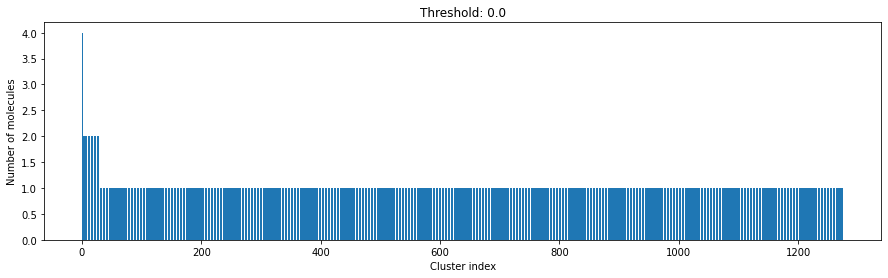

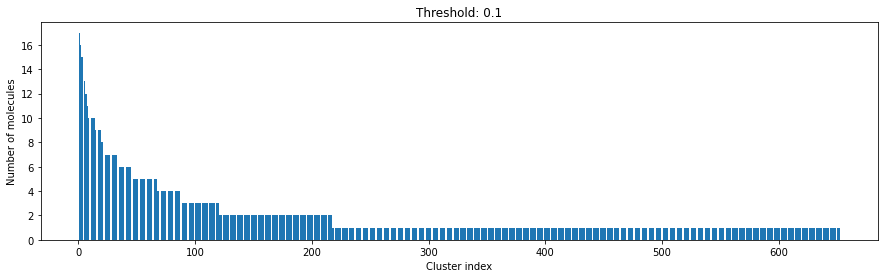

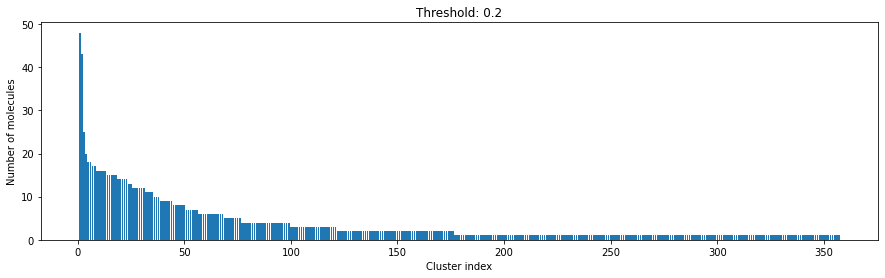

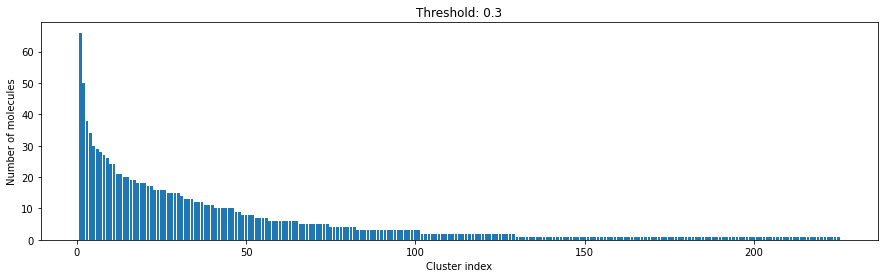

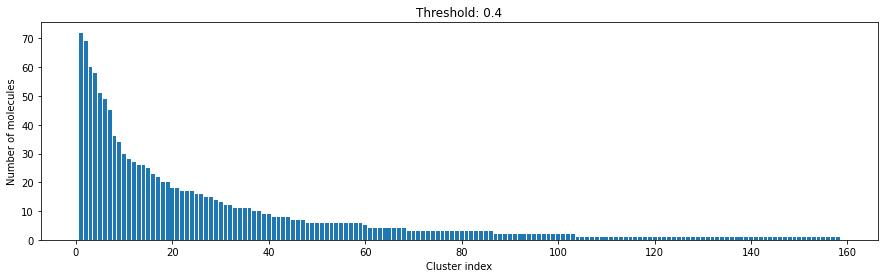

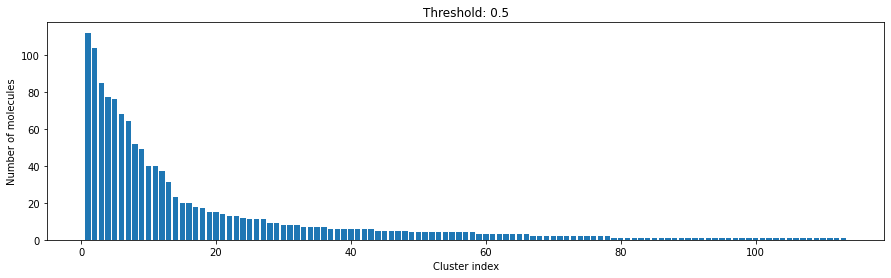

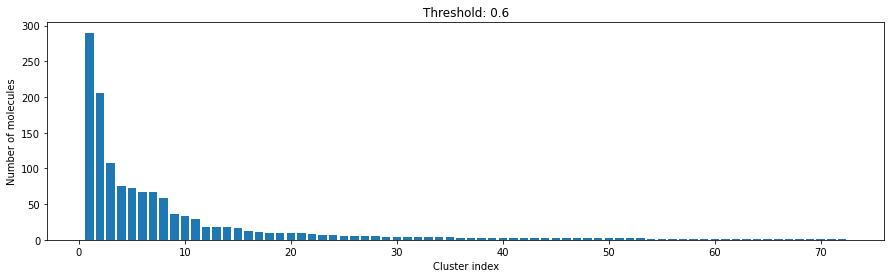

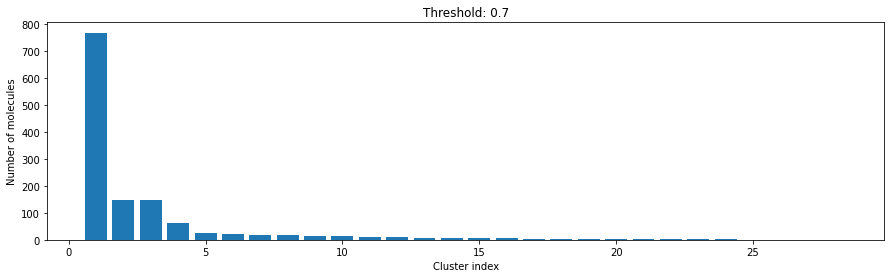

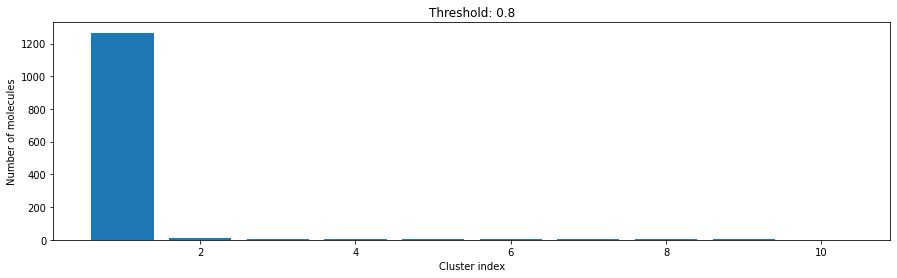

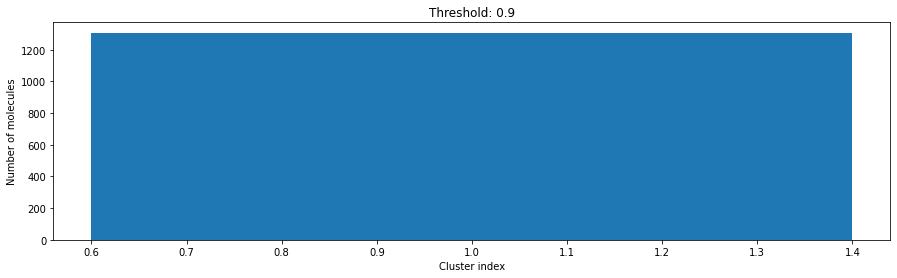

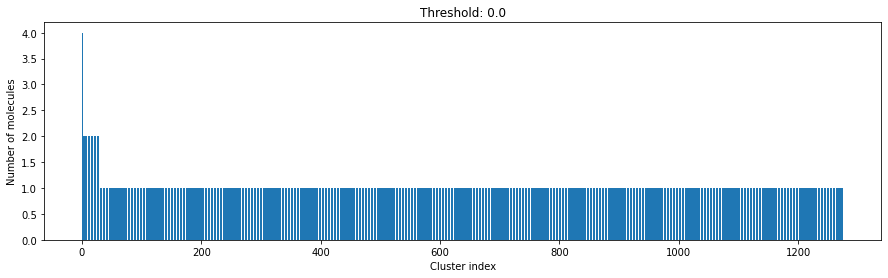

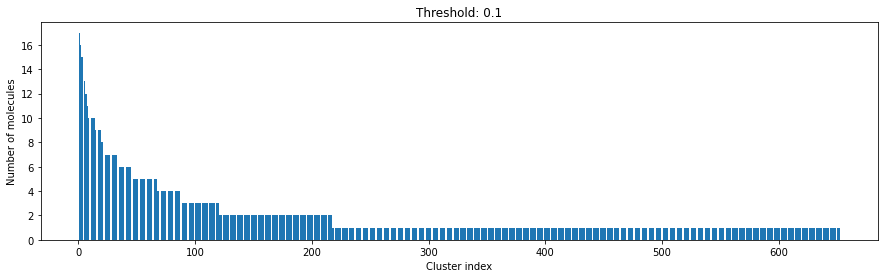

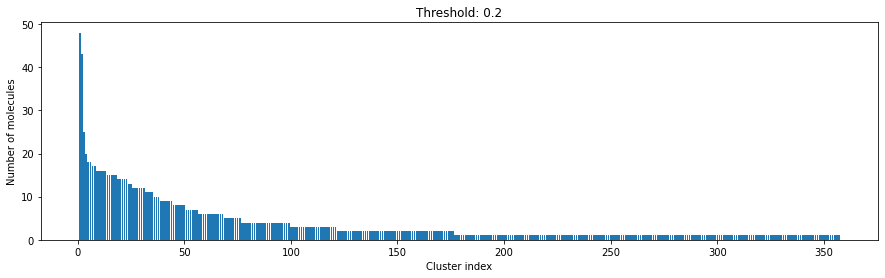

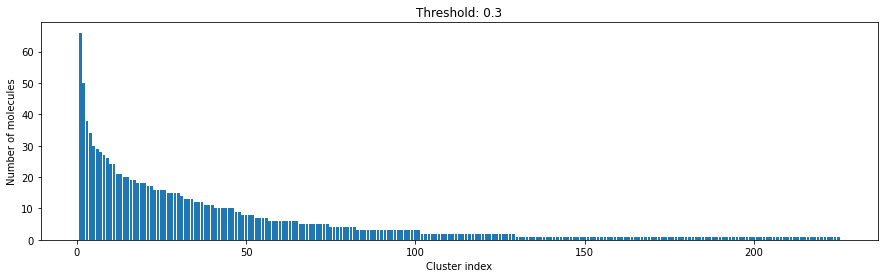

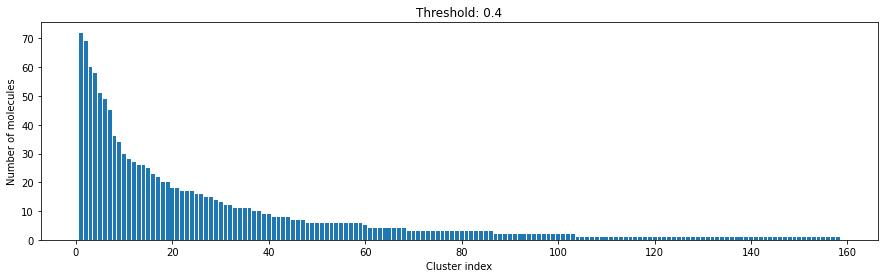

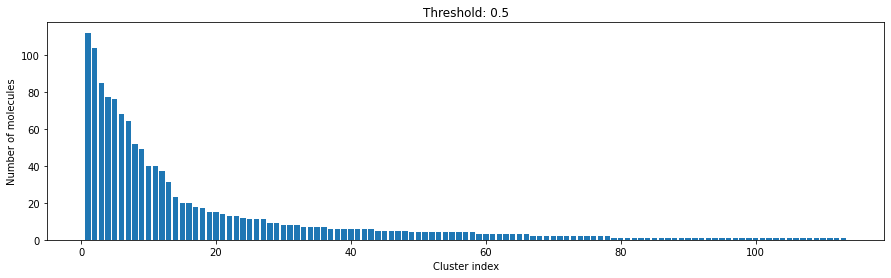

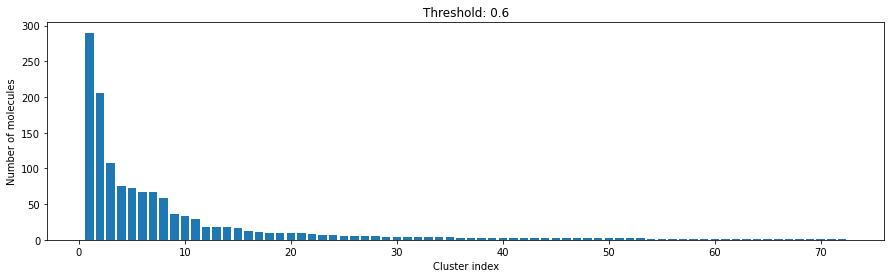

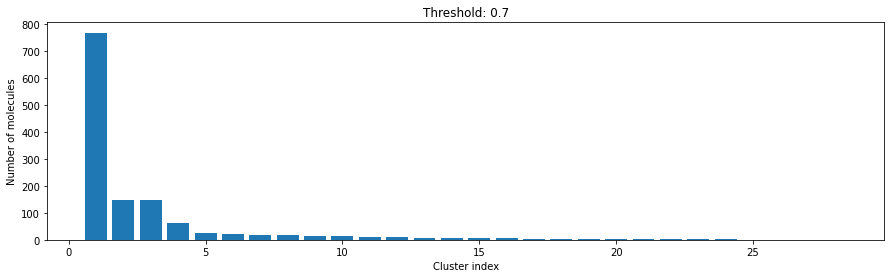

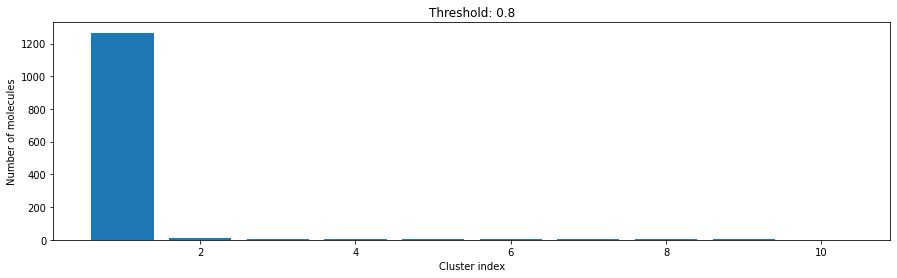

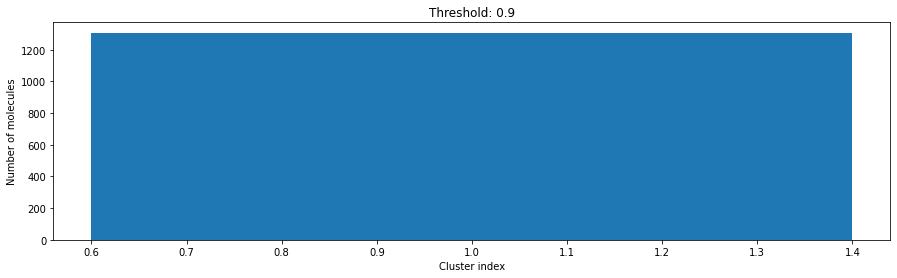

In [10]:
for cutoff in numpy.arange(0.0, 1.0, 0.1):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

### Clustering avec un seuil de similarité de 0.2

In [12]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.2)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  357
# clusters with only 1 compound:  181
# clusters with >5 compounds:  68
# clusters with >25 compounds:  2
# clusters with >100 compounds:  0


### Similarité intra-groupe

In [13]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


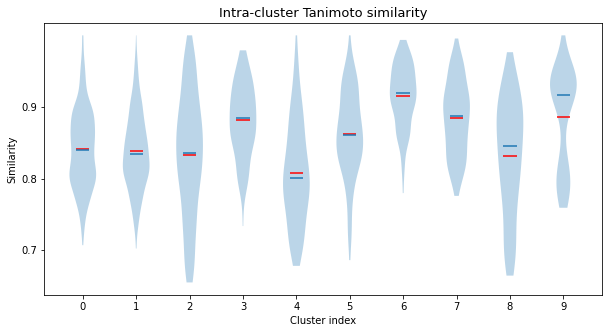

In [14]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

## Représentation des clusters
### Calcul de la matrice de similarité

In [15]:
similarityMatrix = getMatrixSimilarity(drugList=molecules.molecule_chembl_id, molecularSignature = fingerprints, similarityMeasure= "Tanimoto")

100%|██████████| 1308/1308 [00:00<00:00, 4598.53it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


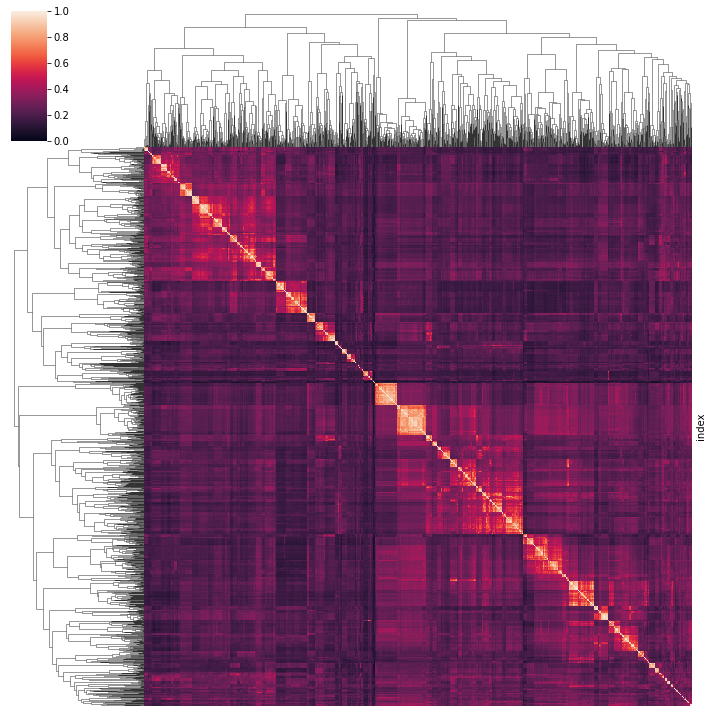

In [16]:
g = sns.clustermap(similarityMatrix,
                   vmin=0, 
                   vmax=1,
                   yticklabels=False,
                   xticklabels=False)
g